Google Speech Command Dataset: https://www.kaggle.com/datasets/mok0na/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import librosa
import librosa.display

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
myDrive_path = 'gdrive/Shareddrives/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


A portion of pre-processing techniques are borrowed from the [blog](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8) at Towards Data Science.

In [ ]:
# access sampling rate
wav_path = myDrive_path + 'CS172B Project/GoogleSpeech/speech_commands_v0.02/go/050170cb_nohash_3.wav'
sr = librosa.get_samplerate(wav_path)
print(sr)

16000


new_sr: 16000
(16000,)
(1025, 32)
(128, 32)
(12, 32)


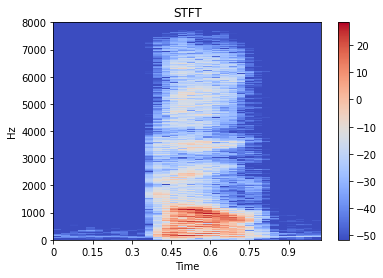

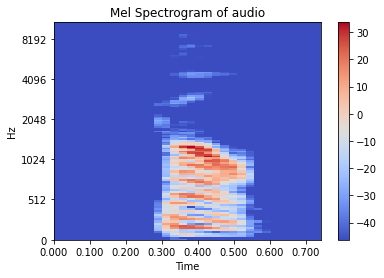

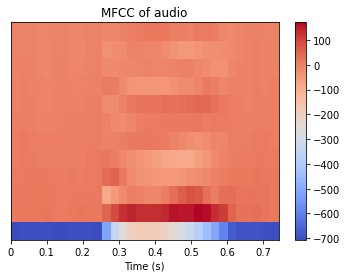

In [ ]:
# Load in the sounds
audio, sr = librosa.load(wav_path, sr=sr)  # , sr=sr
print("new_sr:", sr)
# # Mask audio to trim out dead noise (simple data cleaning)
# audio = env_mask(audio, 0.005)
print(audio.shape)


stft = librosa.stft(audio)  # STFT of y
stft = librosa.amplitude_to_db(np.abs(stft))


# Create Mel Spectrograms of sounds
mel = librosa.feature.melspectrogram(audio, sr=sr)
# Convert amplitudes to dB
mel = librosa.amplitude_to_db(mel)

mfcc = librosa.feature.mfcc(audio, sr=sr, n_mfcc=12)

print(stft.shape)
print(mel.shape)
print(mfcc.shape)
# plot stft
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
i = librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz', ax=ax)
plt.colorbar(i)
ax.set(title="STFT")
plt.show()

# Plot mel spectrograms
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set(title = 'Mel Spectrogram of audio')
i = librosa.display.specshow(mel, x_axis='time', y_axis='mel', ax=ax)
plt.colorbar(i)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set(title = 'MFCC of audio')
i = librosa.display.specshow(mfcc, x_axis='s', ax=ax)
plt.colorbar(i)
plt.show()

length = 1.0s


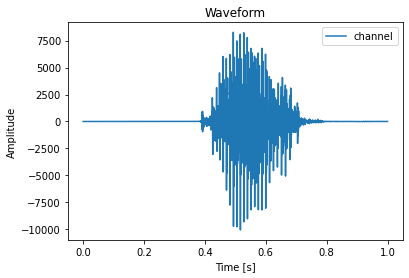

In [ ]:
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io

samplerate, data = wavfile.read(wav_path)
# print(f"number of channels = {data.shape[1]}")

length = data.shape[0] / samplerate
print(f"length = {length}s")

import matplotlib.pyplot as plt
import numpy as np
time = np.linspace(0., length, data.shape[0])
plt.title("Waveform")
plt.plot(time, data, label="channel")
# plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# Configuration Set up

In [ ]:
# Using Google Speech recognition Dataset
# Dataset link: http://www.doc.ic.ac.uk/~pam213/co460_files/
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt
import torch.nn.functional as F

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)

import torch
use_GPU = torch.cuda.is_available()
device = torch.device("cuda" if use_GPU else "cpu")
if use_GPU:
    torch.cuda.manual_seed_all(42)
print("Using GPU: {}".format(use_GPU))

Using GPU: True


# Construct Dataset

In [ ]:
# Dataset Preprocessing 
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())#  - 10 + 1 # the 10 auxiliary words serve as negative example

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).astype(np.float32)

        """
        # Short-time Fourier transform
        stft = librosa.stft(sample)  # STFT of y
        sample = librosa.amplitude_to_db(np.abs(stft))
        """

        window = 16
        step = 4
        num_frame = (sample.shape[1]-window)//step + 1
        frames = np.zeros((num_frame, sample.shape[0], window))
        for i in range(num_frame):
            frames[i] = sample[:, i*step : i*step+window]

        
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################

        label = torch.full([num_frame], self.label_list[idx])

        return frames, label

    def get_classes(self):
        return ["zero", "one", "two", "three", "four"]
        # , "three", "four", "five", "six", "seven", "eight", "nine", "_background_noise_"
        # , "bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [ ]:
# load the speech recognition dataset using pytorch dataloader
data_folder = "gdrive/Shareddrives/CS172B Project/GoogleSpeech"

train_dataset = SpeechCommandsDataset(data_folder, "train")
valid_dataset = SpeechCommandsDataset(data_folder, "valid")
test_dataset = SpeechCommandsDataset(data_folder, "test")

# set hyperparameters, but you can configure the hyperparameters by yourself during the training
batch_size = 50
num_epochs = 15
valid_n_steps = 20

# load dataset in dataloader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [ ]:
batch, labels = next(iter(train_loader))
frame_size = batch.shape[2:]
print(frame_size)
print(batch.shape)
print(labels.shape)
train_dataset.number_of_classes

torch.Size([20, 16])
torch.Size([50, 5, 20, 16])
torch.Size([50, 5])


5

#CNN-based Recurrent network implementation

In [ ]:
class CRNN(nn.Module):
    def __init__(self, input_shape, in_channels, hidden_channels, out_channels, n_class, rnn_layer_num, mode="RNN"): # samples_per_frame
        super(CRNN, self).__init__()
        self.n_class = n_class
        self.rnn_layer_num = rnn_layer_num
        self.mode = mode
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1, padding_mode="reflect", dtype=float)
        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect", dtype=float)
        self.rnn_in_dim = out_channels*(input_shape[0]-1)*(input_shape[1]-1)
        if mode == "RNN":
            self.rnn = nn.RNN(input_size=self.rnn_in_dim, hidden_size=self.rnn_in_dim, num_layers=rnn_layer_num, batch_first=True)
        elif mode == "LSTM":
            self.lstm = nn.LSTM(self.rnn_in_dim, self.rnn_in_dim, rnn_layer_num, batch_first=True)
        else:
            raise ValueError("mode {} not defined".format(mode))

        self.linear = nn.Linear(self.rnn_in_dim, n_class)
        self.softmax = nn.Softmax(dim=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.hidden = torch.rand(self.rnn_in_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Parameters
        ----------
        x: BxLxHxW
        """
        B, L, H, W = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        rnn_inputs = []  # should have shape = B x L x rnn_in_dim
        
        for l in range(L):
            x_conv = x[:, l, :, :].view(B, 1, H, W)
            x_conv = self.relu(self.conv1(x_conv))
            x_conv = self.relu(self.maxpool(self.conv2(x_conv)))
            x_rnn = x_conv.view(x_conv.shape[0], -1)  # flatten feature maps into row vectors (B x rnn_in_dim)
            rnn_inputs.append(x_rnn)

        rnn_inputs = torch.stack(rnn_inputs, dim=1).float()  # B x L x rnn_in_dim
        if torch.cuda.is_available():
            rnn_inputs = rnn_inputs.cuda()
        
        h = torch.zeros(self.rnn_layer_num, B, self.rnn_in_dim).float()
        if torch.cuda.is_available():
            h = h.cuda()
            
        if self.mode == "RNN":
            outputs, _ = self.rnn(rnn_inputs, h)   # B x L x out_dim
        elif self.mode == "LSTM":
            c = torch.zeros(self.rnn_layer_num, B, self.rnn_in_dim).float()
            if torch.cuda.is_available():
                c = c.cuda()
            outputs, _ = self.lstm(rnn_inputs, (h, c))

        outs = []
        for l in range(L):
            out = self.softmax(self.linear(outputs[:, l, :].view(B, -1)))  # B x out_dim
            outs.append(out)
        
        Y = torch.stack(outs, dim=1)  # B x L x out_dim
        if torch.cuda.is_available():
            Y = Y.cuda()
        
        return Y

# Training

In [ ]:
## define your hyper-parameters
imput_channels = 1
hidden_channels = 5
output_channels = 3
rnn_layer_num = 1
mode = "LSTM"
bias = True
learning_rate = 0.001


model = CRNN(frame_size, imput_channels, hidden_channels, output_channels, train_dataset.number_of_classes, rnn_layer_num, mode)
model = model.float()
if torch.cuda.is_available():
    model.cuda()

# Define your loss function
criterion = nn.CrossEntropyLoss()

## Define your optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam([var1, var2], lr=0.0001)


print(model)

CRNN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv2): Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (lstm): LSTM(855, 855, batch_first=True)
  (linear): Linear(in_features=855, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
  (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [ ]:
#--------------------------------------------#
# *** Start Training on Bidirectional RNN ***#
# for this part, you **do not** need to modify any of the code
# please only test your model performance through the training.
loss_list = []
iteration = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        #audio = torch.from_numpy(frames).view(frames.shape[0], 1, frames.shape[1], frames.shape[2]).float()
        if torch.cuda.is_available():
            audio = Variable(audio.float().cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.float())
            #audio = torch.from_numpy(frames).view(frames.shape[0], 1, frames.shape[1], frames.shape[2]).float()
            labels = Variable(labels)

        optimizer.zero_grad()
        
        outputs = model(audio)

        loss = Variable(torch.Tensor([0]).float())
        if torch.cuda.is_available():
            loss = loss.cuda()

        for l in range(outputs.shape[1]):
            loss = loss + criterion(outputs[:, l, :], labels[:, l])

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iteration += 1

        if iteration % valid_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.float().cuda())
                else:
                    audio = Variable(audio.float())

                outputs = model(audio)

                predicted = torch.argmax(outputs.data, 2)

                total += labels.view(-1).shape[0]

                if torch.cuda.is_available():
                    correct += (predicted.to(device) == labels.to(device)).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.float().cuda())
                    else:
                        audio = Variable(audio.float())

                    outputs = model(audio)

                    predicted = torch.argmax(outputs.data, 2)

                    total += labels.view(-1).shape[0]

                    if torch.cuda.is_available():
                        correct += (predicted.to(device) == labels.to(device)).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy
                torch.save(model, myDrive_path + "CS172B Project/CRNN_" + model.mode)

            print('Iteration: {}, epoch: {}.\t Loss: {:3f}. V-Accuracy: {:3f}%  T-Accuracy: {:3f}%'.format(iteration, epoch, loss.item(), v_accuracy, reported_t_accuracy))
        


Iteration: 4640, epoch: 0.	 Loss: 5.034352. V-Accuracy: 90.447762%  T-Accuracy: 89.265884%
Iteration: 4660, epoch: 0.	 Loss: 4.749929. V-Accuracy: 90.735214%  T-Accuracy: 89.265884%
Iteration: 4680, epoch: 0.	 Loss: 4.863745. V-Accuracy: 90.668877%  T-Accuracy: 89.265884%
Iteration: 4700, epoch: 0.	 Loss: 4.967093. V-Accuracy: 90.668877%  T-Accuracy: 89.265884%
Iteration: 4720, epoch: 0.	 Loss: 4.967876. V-Accuracy: 90.646767%  T-Accuracy: 89.265884%
Iteration: 4740, epoch: 0.	 Loss: 4.836609. V-Accuracy: 90.790497%  T-Accuracy: 89.265884%
Iteration: 4760, epoch: 0.	 Loss: 4.791533. V-Accuracy: 90.724159%  T-Accuracy: 89.265884%
Iteration: 4780, epoch: 0.	 Loss: 4.935363. V-Accuracy: 90.602547%  T-Accuracy: 89.265884%
Iteration: 4800, epoch: 0.	 Loss: 4.832655. V-Accuracy: 90.713104%  T-Accuracy: 89.265884%
Iteration: 4820, epoch: 0.	 Loss: 5.208143. V-Accuracy: 90.690994%  T-Accuracy: 89.265884%
Iteration: 4840, epoch: 0.	 Loss: 4.737118. V-Accuracy: 90.757324%  T-Accuracy: 89.265884%

In [ ]:
# torch.save(model, myDrive_path + "CS172B Project/CRNN")